Load Data

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to SQLite Database
conn = sqlite3.connect('../swiss_travel.db')  # Adjust path if necessary

# Load and join data with SQL
query = """
SELECT 
*
FROM hotels h
"""

df = pd.read_sql_query(query, conn)

df.head()

,hotel,place,price_per_night,rating,review_counter,price_cleaned,review_counter_cleaned,rating_cleaned,place_cleaned
0,Hard Rock Hotel Davos,Davos,€ 225,"8,4",1.653 Bewertungen,225.0,1653.0,8.4,Davos
1,Good Night Inn,Brig,€ 138,"8,2",2.669 Bewertungen,138.0,2669.0,8.2,Brig
2,Agriturismo Regusci,Camorino,€ 165,"8,7",765 Bewertungen,165.0,765.0,8.7,Camorino
3,Ustreia Orta,Lohn,€ 169,"9,6",52 Bewertungen,169.0,52.0,9.6,Lohn
4,Hotel Drei Könige,Einsiedeln,€ 177,"8,6",948 Bewertungen,177.0,948.0,8.6,Einsiedeln


Correlation Analysis: Price vs. Rating

Korrelationskoeffizient: 0.30
P-Wert: 0.0000000000000000000002700
Signifikanter Zusammenhang (p < 0.05)


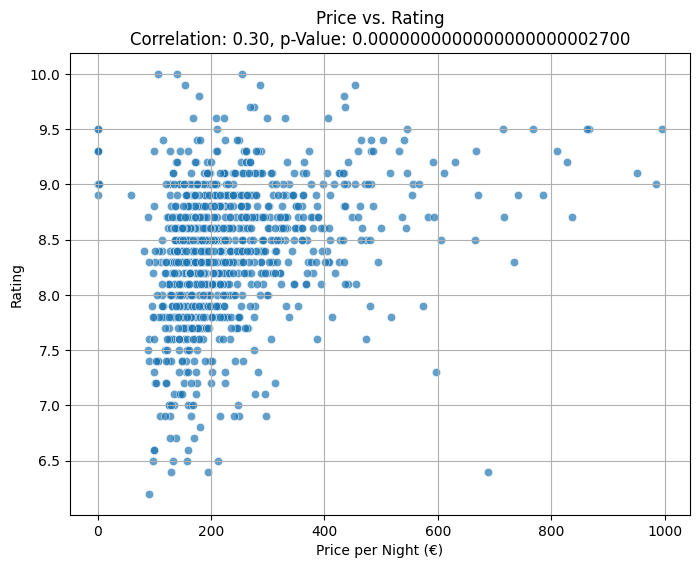

In [3]:
import os
# NaN-Werte entfernen
filtered_df = df[['price_cleaned', 'rating_cleaned']].dropna()

corr_price_rating, p_value_price_rating = pearsonr(filtered_df['price_cleaned'], filtered_df['rating_cleaned'])

print(f"Korrelationskoeffizient: {corr_price_rating:.2f}")
print(f"P-Wert: {p_value_price_rating:.25f}")

if p_value_price_rating < 0.05:
    print("Signifikanter Zusammenhang (p < 0.05)")
else:
    print("Kein signifikanter Zusammenhang (p >= 0.05)")

# Scatterplot Price vs. Rating
plt.figure(figsize=(8,6))
sns.scatterplot(x='price_cleaned', y='rating_cleaned', data=df, alpha=0.7)
plt.title(f'Price vs. Rating\nCorrelation: {corr_price_rating:.2f}, p-Value: {p_value_price_rating:.25f}')
plt.xlabel('Price per Night (€)')
plt.ylabel('Rating')
plt.grid(True)

static_folder = os.path.join(os.getcwd(), 'app', 'static')
if not os.path.exists(static_folder):
    os.makedirs(static_folder)

# Save the figure BEFORE plt.show()
plt.savefig('../app/static/price_vs_rating.png', bbox_inches='tight')
plt.show()
plt.close()

Price Distribution per Region (Top 20 most popular locations)

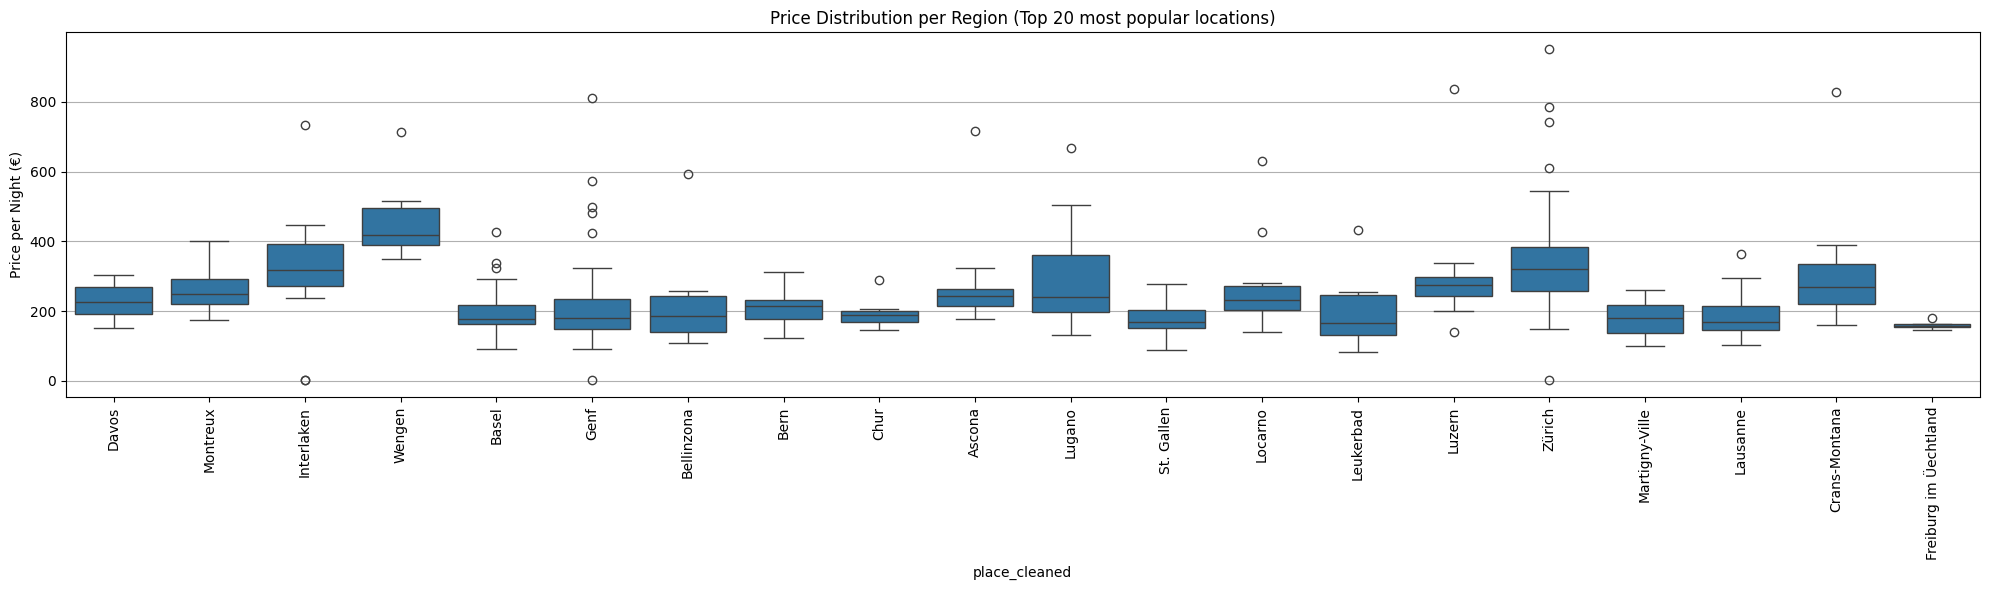

In [ ]:
# Find the top 20 locations by count
top_locations = df['place_cleaned'].value_counts().nlargest(20).index

# Filter the DataFrame to only include these locations
filtered_df = df[df['place_cleaned'].isin(top_locations)]

# Plot the boxplot for the top 20 locations
plt.figure(figsize=(20,6))
sns.boxplot(x='place_cleaned', y='price_cleaned', data=filtered_df)
plt.xticks(rotation=90, fontsize=10)
plt.title('Price Distribution per Region (Top 20 most popular locations)')
plt.ylabel('Price per Night (€)')
plt.grid(axis='y')
plt.tight_layout()
# Save the figure BEFORE plt.show()
plt.savefig('../app/static/top20_loc_price_distr', bbox_inches='tight')
plt.show()
plt.close()

Review Count vs. Rating Analysis

Korrelationskoeffizient: -0.18
P-Wert: 0.0000000118
Signifikanter Zusammenhang (p < 0.05)


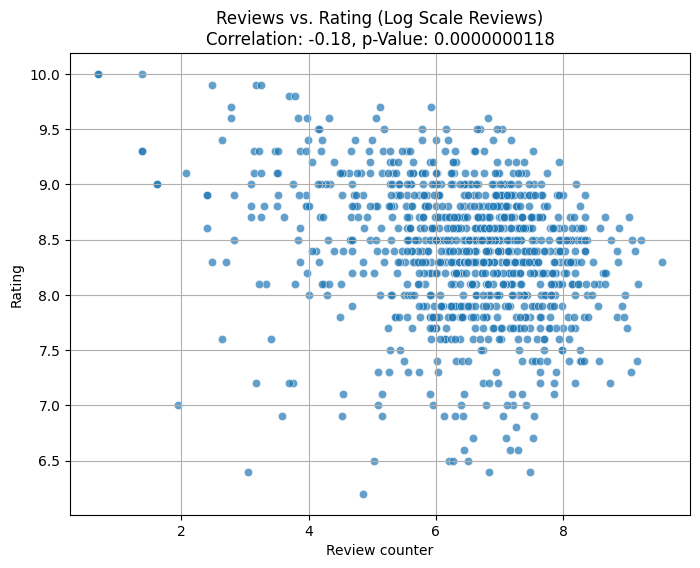

In [11]:
# NaN-Werte entfernen
filtered_df_reviews = df[['review_counter_cleaned', 'rating_cleaned']].dropna()

# Pearson-Korrelation und p-Wert berechnen
corr_reviews_rating, p_value_reviews_rating = pearsonr(filtered_df_reviews['review_counter_cleaned'], filtered_df_reviews['rating_cleaned'])

print(f"Korrelationskoeffizient: {corr_reviews_rating:.2f}")
print(f"P-Wert: {p_value_reviews_rating:.10f}")

if p_value_reviews_rating < 0.05:
    print("Signifikanter Zusammenhang (p < 0.05)")
else:
    print("Kein signifikanter Zusammenhang (p >= 0.05)")

# Scatterplot: Log(Review Count) vs. Rating
plt.figure(figsize=(8,6))
sns.scatterplot(x=np.log1p(filtered_df_reviews['review_counter_cleaned']), y=filtered_df_reviews['rating_cleaned'], alpha=0.7)
plt.title(f'Reviews vs. Rating (Log Scale Reviews)\nCorrelation: {corr_reviews_rating:.2f}, p-Value: {p_value_reviews_rating:.10f}')
plt.xlabel('Review counter')
plt.ylabel('Rating')
plt.grid(True)

# Save the figure BEFORE plt.show()
plt.savefig('../app/static/reviews_vs_rating', bbox_inches='tight')
plt.show()
plt.close()

Price Category Analysis

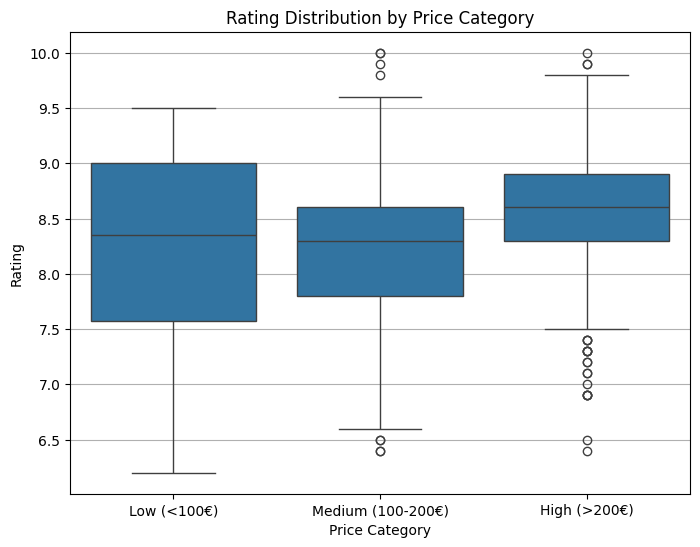

In [10]:
bins = [0, 100, 200, np.inf]
labels = ['Low (<100€)', 'Medium (100-200€)', 'High (>200€)']
df['price_category'] = pd.cut(df['price_cleaned'], bins=bins, labels=labels)

plt.figure(figsize=(8,6))
sns.boxplot(x='price_category', y='rating_cleaned', data=df)
plt.title('Rating Distribution by Price Category')
plt.ylabel('Rating')
plt.xlabel('Price Category')
plt.grid(axis='y')

# Save the figure BEFORE plt.show()
plt.savefig('../app/static/rating_by_price_cat', bbox_inches='tight')
plt.show()
plt.close()

/tmp/ipykernel_85389/162190099.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


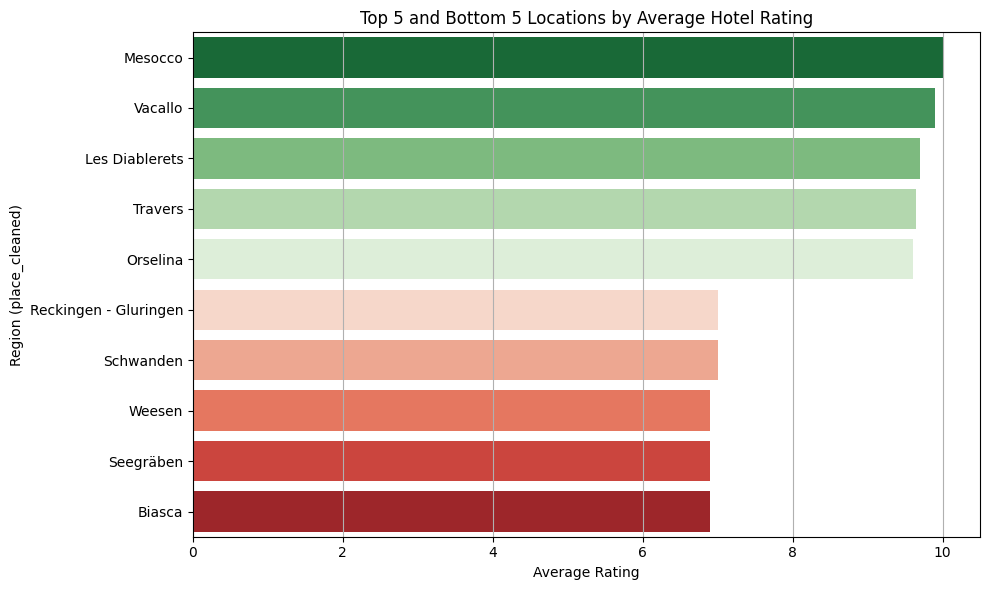

In [7]:
# Group by Location and calculate average rating and count
region_rating = df.groupby('place_cleaned').agg(
    avg_rating=('rating_cleaned', 'mean'),
    count=('hotel', 'count')
).reset_index()

# Filter out regions with avg_rating <= 0
region_rating_filtered = region_rating[region_rating['avg_rating'] > 0]

# Sort by average rating
region_rating_sorted = region_rating_filtered.sort_values(by='avg_rating', ascending=False)

# Select Top 5 and Bottom 5
top_5 = region_rating_sorted.head(5).copy()
bottom_5 = region_rating_sorted.tail(5).copy()

# Add a column for type (Top or Bottom)
top_5['type'] = 'Top 5'
bottom_5['type'] = 'Bottom 5'

# Combine
combined = pd.concat([top_5, bottom_5])

# Create color palette: boldest green for highest, boldest red for lowest
greens = sns.color_palette("Greens", len(top_5))[::-1]  # Reverse so boldest is first
reds = sns.color_palette("Reds", len(bottom_5))

# Map colors
palette = {}
for i, region in enumerate(top_5['place_cleaned']):
    palette[region] = greens[i]
for i, region in enumerate(bottom_5['place_cleaned']):
    palette[region] = reds[i]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x='avg_rating',
    y='place_cleaned',
    data=combined,
    palette=palette
)

plt.title('Top 5 and Bottom 5 Locations by Average Hotel Rating')
plt.xlabel('Average Rating')
plt.ylabel('Region (place_cleaned)')
plt.grid(axis='x')
plt.tight_layout()

# Save the figure BEFORE plt.show()
plt.savefig('../app/static/top5_bottom5', bbox_inches='tight')
plt.show()
plt.close()

In [8]:
df

,hotel,place,price_per_night,rating,review_counter,price_cleaned,review_counter_cleaned,rating_cleaned,place_cleaned,price_category
0,Hard Rock Hotel Davos,Davos,€ 225,"8,4",1.653 Bewertungen,225.0,1653.0,8.4,Davos,High (>200€)
1,Good Night Inn,Brig,€ 138,"8,2",2.669 Bewertungen,138.0,2669.0,8.2,Brig,Medium (100-200€)
2,Agriturismo Regusci,Camorino,€ 165,"8,7",765 Bewertungen,165.0,765.0,8.7,Camorino,Medium (100-200€)
3,Ustreia Orta,Lohn,€ 169,"9,6",52 Bewertungen,169.0,52.0,9.6,Lohn,Medium (100-200€)
4,Hotel Drei Könige,Einsiedeln,€ 177,"8,6",948 Bewertungen,177.0,948.0,8.6,Einsiedeln,Medium (100-200€)
...,...,...,...,...,...,...,...,...,...,...
974,HÔTEL DE VILLE - La Baie Du Lac,LʼAbbaye,€ 129,"7,0",383 Bewertungen,129.0,383.0,7.0,LʼAbbaye,Medium (100-200€)
975,Vreneli,Mitlödi,€ 159,"9,3",24 Bewertungen,159.0,24.0,9.3,Mitlödi,Medium (100-200€)
976,ODELYA - Stadthotel im Park,"Basel Stadtzentrum, Basel",€ 292,"8,7",1.182 Bewertungen,292.0,1182.0,8.7,Basel,High (>200€)
977,Hotel Montana,"Saint-Gervais / des Grottes, Genf",€ 195,"7,7",1.124 Bewertungen,195.0,1124.0,7.7,Genf,Medium (100-200€)
